# Random forest regression with hyperparameter tuning by GPyOpt
Reference : <br>
http://krasserm.github.io/2018/03/21/bayesian-optimization/ <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

### Import library and dataset

In [1]:
%matplotlib inline
%pylab inline  
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Random forest
from sklearn.ensemble import RandomForestRegressor

# Cross validation
from sklearn.model_selection import (KFold, ShuffleSplit)
from sklearn.metrics import mean_squared_error, r2_score

#GPy
import GPy, GPyOpt
from GPyOpt.methods import BayesianOptimization

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load dataset
df = pd.read_csv('glass.csv')
print(df.shape)
df.head()

(214, 11)


,Id number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df_test = df.drop(df.columns[[0, 10]], axis=1)
print(df_test.shape)
df_test.head()

(214, 9)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [4]:
X = df_test.iloc[:, 1:]
y = df_test.iloc[:, :1]

In [5]:
print(X.shape)
X.head()

(214, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [6]:
print(y.shape)
y.head()

(214, 1)


,RI
0,1.52101
1,1.51761
2,1.51618
3,1.51766
4,1.51742


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(171, 8) (43, 8) (171, 1) (43, 1)


### Default

In [8]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [9]:
pred_rfr = rfr.predict(X_test)
R2_rfr = r2_score(pred_rfr, y_test)
print('R2 = ', R2_rfr)

R2 =  0.644955023671855


### Hyperparameter tuning using GPyOpt

In [10]:
# GPyOpt for XGBoost regression

bounds_rfr = [
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (5, 500)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 100)},
    {'name': 'min_sample_split', 'type': 'discrete', 'domain': (2, 10)},
    {'name': 'min_samples_leaf', 'type': 'discrete', 'domain': (1, 5)}
]

# Optimization objective function

def rmse_rfr(*args):
    params = args[0]
    
    rfr = RandomForestRegressor(n_estimators = int(params[0][0]),
                                max_depth = int(params[0][1]),
                                min_samples_split = int(params[0][2]),
                                min_samples_leaf = int(params[0][3]),
                                bootstrap = True,
                                random_state = 0,
                                criterion = 'mse')
                
    rfr.fit(X_train, y_train)
    
    pred_rfr = rfr.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(pred_rfr, y_test))
    
    return RMSE

In [11]:
%%time

optimizer = BayesianOptimization(f = rmse_rfr, domain = bounds_rfr)
optimizer.run_optimization(max_iter = 50)

Wall time: 17.7 s


In [12]:
optimizer.x_opt

array([  5., 100.,   2.,   1.])

In [13]:
rfr_best = RandomForestRegressor(n_estimators = int(optimizer.x_opt[0]),
                                 max_depth = int(optimizer.x_opt[1]),
                                 min_samples_split = int(optimizer.x_opt[2]),
                                 min_samples_leaf = int(optimizer.x_opt[3]),
                                 bootstrap = True,
                                 random_state = 0,
                                 criterion = 'mse')

rfr_best.fit(X_train, y_train)
y_pred_rfr = rfr_best.predict(X_test)

print('R2 = ', '{:.4}'.format(r2_score(y_pred_rfr, y_test)))

R2 =  0.8123


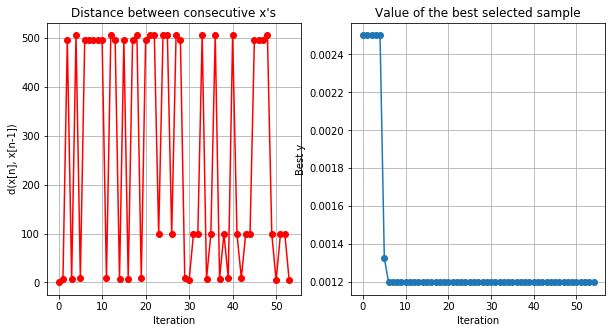

In [14]:
optimizer.plot_convergence()

### Check model performance by CV

R2 =   0.9364


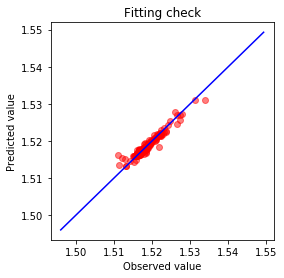

In [15]:
# Use all data
X_train, y_train = X, y

rfr_best = RandomForestRegressor(n_estimators = int(optimizer.x_opt[0]),
                                 max_depth = int(optimizer.x_opt[1]),
                                 min_samples_split = int(optimizer.x_opt[2]),
                                 min_samples_leaf = int(optimizer.x_opt[3]),
                                 bootstrap = True,
                                 random_state = 0,
                                 criterion = 'mse')

rfr_best.fit(X_train, y_train)
y_pred = rfr_best.predict(X_train)

print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.99 * y.min()
slp_1_end   = 1.01 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import (KFold, ShuffleSplit)
split_num = 5

cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)

print('Check best model perfromance in the folds')
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    y_pred = rfr_best.predict(X_test)
    R2_reg = r2_score(y_test, y_pred)
    print(' {:.4}'.format(R2_reg))

Check best model perfromance in the folds
 0.962
 0.9413
 0.916
 0.9448
 0.9021
